In [102]:

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
import os

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

# Add Identification directory to path for baseline_inference import
identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore

In [103]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs


In [104]:
scaler = joblib.load(os.path.join('../data', 'scaler.pkl'))
scalerU = joblib.load(os.path.join('../data', 'scalerU.pkl'))

In [105]:
u = np.zeros((3, 1))
baseline_inference.get_x(np.zeros((3, 1)))
for i in range(10000):
    y = baseline_inference.y_plus(u)
print(scaler.inverse_transform(y.reshape(1, -1))[0])

[59.4503   74.440544 61.206383]


In [106]:
u = np.array([[0.0], [1.0], [0.0]])
baseline_inference.get_x(np.zeros((3, 1)))
for i in range(1000):
    y = baseline_inference.y_plus(u)
print(scaler.inverse_transform(y.reshape(1, -1))[0])

[61.26848  71.997475 63.062172]


In [107]:
u = u = np.array([[1.0], [0.0], [0.0]])
baseline_inference.get_x(np.zeros((3, 1)))
for i in range(1000):
    y = baseline_inference.y_plus(u)
print(scaler.inverse_transform(y.reshape(1, -1))[0])

[48.651257 59.68051  48.512825]


In [108]:
u = u = np.array([[0.0], [0.0], [1.0]])
baseline_inference.get_x(np.zeros((3, 1)))
for i in range(1000):
    y = baseline_inference.y_plus(u)
print(scaler.inverse_transform(y.reshape(1, -1))[0])

[63.231937 80.21634  63.595726]


In [109]:
u = np.zeros((3, 1))
baseline_inference.get_x(np.zeros((3, 1)))
for i in range(1000):
    y = baseline_inference.y_plus(u)
print(scaler.inverse_transform(y.reshape(1, -1))[0])

[59.449764 74.439804 61.205906]


## Inverse Steady State Analysis

Now let's solve the inverse problem: given desired output(s), find all possible input combinations.

In [110]:
# Get the A, B matrices from the baseline model
A = baseline_inference.A
B = baseline_inference.B

print(f"A shape: {A.shape}")
print(f"B shape: {B.shape}")

# For steady state: x_ss = (I - A)^(-1) @ B @ u_ss
# Since decoder is nonlinear (MLP), we need to compute G numerically
nx = A.shape[0]
I_matrix = np.eye(nx)

# Compute steady-state gain matrix numerically
# G[i,j] = d(y_ss[i])/d(u[j]) 
# We'll compute this by finite differences at u=0
def compute_steady_state_output(u_scaled):
    """Given scaled input, compute steady-state output (scaled)."""
    x_ss = inv(I_matrix - A) @ B @ u_scaled.reshape(-1, 1)
    # Use decoder to get output
    import torch
    y_ss = baseline_inference.problem.nodes[4]({"x": torch.from_numpy(x_ss.T).float()})
    y_ss = y_ss["yhat"][0].detach().numpy().flatten()
    return y_ss

# Compute numerical Jacobian (steady-state gain matrix)
nu = 3
ny = 3
G = np.zeros((ny, nu))
u0 = np.zeros(nu)
y0 = compute_steady_state_output(u0)
epsilon = 1e-6

for j in range(nu):
    u_pert = u0.copy()
    u_pert[j] += epsilon
    y_pert = compute_steady_state_output(u_pert)
    G[:, j] = (y_pert - y0) / epsilon

print(f"\nSteady-state gain matrix G (numerical Jacobian):")
print(f"G shape: {G.shape}")
print(f"G (scaled):\n{G}")

A shape: (35, 35)
B shape: (35, 3)

Steady-state gain matrix G (numerical Jacobian):
G shape: (3, 3)
G (scaled):
[[-1.49011612 -0.17881393  3.39746475]
 [-1.60932541 -0.29802322  5.06639481]
 [-1.43051147  0.05960464  2.92062759]]


### Problem 1: Find all input combinations for a given output 0 reference

With only 1 constraint (y[0] = target) and 3 inputs, we have 2 degrees of freedom.
We'll parameterize the solution space by fixing 2 inputs and solving for the third.

**Note:** Since the decoder is a nonlinear neural network (MLP), we use a linearized steady-state gain matrix G computed around u=0. For more accurate results (at the cost of speed), use `verify=True` to compute actual steady-state outputs using the nonlinear model.

In [111]:
def find_inputs_for_single_output(output_idx, target_value_ns, u_min_ns, u_max_ns, 
                                  scaler, scalerU, G, num_samples=100, verify=True):
    """
    Find all input combinations that achieve a target for a single output.
    Uses linearized steady-state model (G matrix) for initial search.
    
    Parameters:
    - output_idx: which output to control (0, 1, or 2)
    - target_value_ns: target value in non-scaled units
    - u_min_ns, u_max_ns: input bounds in non-scaled units
    - scaler, scalerU: scalers for outputs and inputs
    - G: steady-state gain matrix (3x3) - linearization around u=0
    - num_samples: number of grid points for each free input dimension
    - verify: if True, compute actual steady-state outputs (slower but accurate)
    
    Returns:
    - valid_inputs_ns: array of valid input combinations (N x 3)
    - resulting_outputs_ns: corresponding outputs (N x 3)
    """
    
    # Scale the target using the scaler's mean and scale for this output
    target = (target_value_ns - scaler.mean_[output_idx]) / scaler.scale_[output_idx]
    
    # We use linearization: y ≈ G @ u (valid near u=0)
    # For a single output: y[output_idx] = G[output_idx, :] @ u
    
    g_row = G[output_idx, :]
    
    valid_inputs = []
    valid_outputs = []
    
    # Create a grid over 2 of the inputs, solve for the third
    u_min_scaled = scalerU.transform(u_min_ns.reshape(1, -1))[0]
    u_max_scaled = scalerU.transform(u_max_ns.reshape(1, -1))[0]
    
    # Try all combinations of fixing 2 inputs and solving for the third
    for solve_idx in range(3):
        # Indices of the free parameters
        free_indices = [i for i in range(3) if i != solve_idx]
        
        # Check if we can solve for this input (coefficient must be non-zero)
        if np.abs(g_row[solve_idx]) < 1e-10:
            continue
        
        # Create grid over the two free inputs
        u_free_0 = np.linspace(u_min_scaled[free_indices[0]], 
                               u_max_scaled[free_indices[0]], num_samples)
        u_free_1 = np.linspace(u_min_scaled[free_indices[1]], 
                               u_max_scaled[free_indices[1]], num_samples)
        
        for uf0 in u_free_0:
            for uf1 in u_free_1:
                # Solve for the third input using linearization
                other_terms = g_row[free_indices[0]] * uf0 + g_row[free_indices[1]] * uf1
                u_solved = (target - other_terms) / g_row[solve_idx]
                
                # Check if solved input is within bounds
                if u_min_scaled[solve_idx] <= u_solved <= u_max_scaled[solve_idx]:
                    # Construct full input vector
                    u_scaled = np.zeros(3)
                    u_scaled[free_indices[0]] = uf0
                    u_scaled[free_indices[1]] = uf1
                    u_scaled[solve_idx] = u_solved
                    
                    # Compute resulting outputs
                    if verify:
                        # Use actual nonlinear model
                        y_scaled = compute_steady_state_output(u_scaled)
                    else:
                        # Use linearization
                        y_scaled = G @ u_scaled
                    
                    valid_inputs.append(u_scaled)
                    valid_outputs.append(y_scaled)
    
    if len(valid_inputs) == 0:
        print(f"No valid input combinations found for y[{output_idx}] = {target_value_ns}")
        return np.array([]), np.array([])
    
    valid_inputs = np.array(valid_inputs)
    valid_outputs = np.array(valid_outputs)
    
    # Convert back to non-scaled
    valid_inputs_ns = scalerU.inverse_transform(valid_inputs)
    valid_outputs_ns = scaler.inverse_transform(valid_outputs)
    
    return valid_inputs_ns, valid_outputs_ns

In [112]:
# Example: Find all input combinations that achieve y[0] = 60.0
target_y0 = 50.0

print(f"Finding all input combinations for y[0] = {target_y0}°C")
print("Note: Using linearized model. Set verify=True for exact nonlinear results (slower).")
print("=" * 70)

# Define input bounds in non-scaled units (physical units)
u_min_ns = np.array([[30.0, 20.0, 0.0]])   # [°C, °C, kg/h]
u_max_ns = np.array([[100.0, 100.0, 50.0]]) # [°C, °C, kg/h]

valid_u, valid_y = find_inputs_for_single_output(
    output_idx=0,
    target_value_ns=target_y0,
    u_min_ns=u_min_ns,
    u_max_ns=u_max_ns,
    scaler=scaler,
    scalerU=scalerU,
    G=G,
    num_samples=50,
    verify=True  # Set to True for exact results using nonlinear decoder
)

print(f"\nFound {len(valid_u)} valid input combinations")

if len(valid_u) > 0:
    print(f"\nFirst 10 combinations:")
    print("  u0 (%)  |  u1 (%)  |  u2 (%) || y0 (°C) | y1 (°C) | y2 (°C)")
    print("-" * 70)
    for i in range(min(10, len(valid_u))):
        print(f"{valid_u[i, 0]:8.2f} | {valid_u[i, 1]:8.2f} | {valid_u[i, 2]:10.2f} || "
              f"{valid_y[i, 0]:7.2f} | {valid_y[i, 1]:7.2f} | {valid_y[i, 2]:7.2f}")

    # Summary statistics
    print(f"\n\nInput ranges for y[0] = {target_y0}:")
    print(f"  u0: [{valid_u[:, 0].min():.2f}, {valid_u[:, 0].max():.2f}] °C")
    print(f"  u1: [{valid_u[:, 1].min():.2f}, {valid_u[:, 1].max():.2f}] °C")
    print(f"  u2: [{valid_u[:, 2].min():.2f}, {valid_u[:, 2].max():.2f}] kg/h")
    print(f"\nResulting output ranges:")
    print(f"  y0: [{valid_y[:, 0].min():.2f}, {valid_y[:, 0].max():.2f}] °C (target: {target_y0:.2f})")
    print(f"  y1: [{valid_y[:, 1].min():.2f}, {valid_y[:, 1].max():.2f}] °C")
    print(f"  y2: [{valid_y[:, 2].min():.2f}, {valid_y[:, 2].max():.2f}] °C")
    print(f"Number of valid solutions: {len(valid_u)}")
else:
    print("\nNo valid solutions found. Try adjusting the target or input bounds.")

Finding all input combinations for y[0] = 50.0°C
Note: Using linearized model. Set verify=True for exact nonlinear results (slower).

Found 3586 valid input combinations

First 10 combinations:
  u0 (%)  |  u1 (%)  |  u2 (%) || y0 (°C) | y1 (°C) | y2 (°C)
----------------------------------------------------------------------
   31.82 |    20.00 |       9.18 ||   40.38 |   54.68 |   39.64
   35.48 |    20.00 |      10.20 ||   39.95 |   55.98 |   39.13
   39.15 |    20.00 |      11.22 ||   39.46 |   57.39 |   38.59
   42.82 |    20.00 |      12.24 ||   38.93 |   58.90 |   38.02
   46.48 |    20.00 |      13.27 ||   38.38 |   60.47 |   37.46
   50.15 |    20.00 |      14.29 ||   37.81 |   62.07 |   36.92
   53.82 |    20.00 |      15.31 ||   37.24 |   63.70 |   36.41
   57.48 |    20.00 |      16.33 ||   36.65 |   65.33 |   35.94
   61.15 |    20.00 |      17.35 ||   36.04 |   66.93 |   35.46
   64.82 |    20.00 |      18.37 ||   35.38 |   68.46 |   34.98


Input ranges for y[0] = 50.0:
 

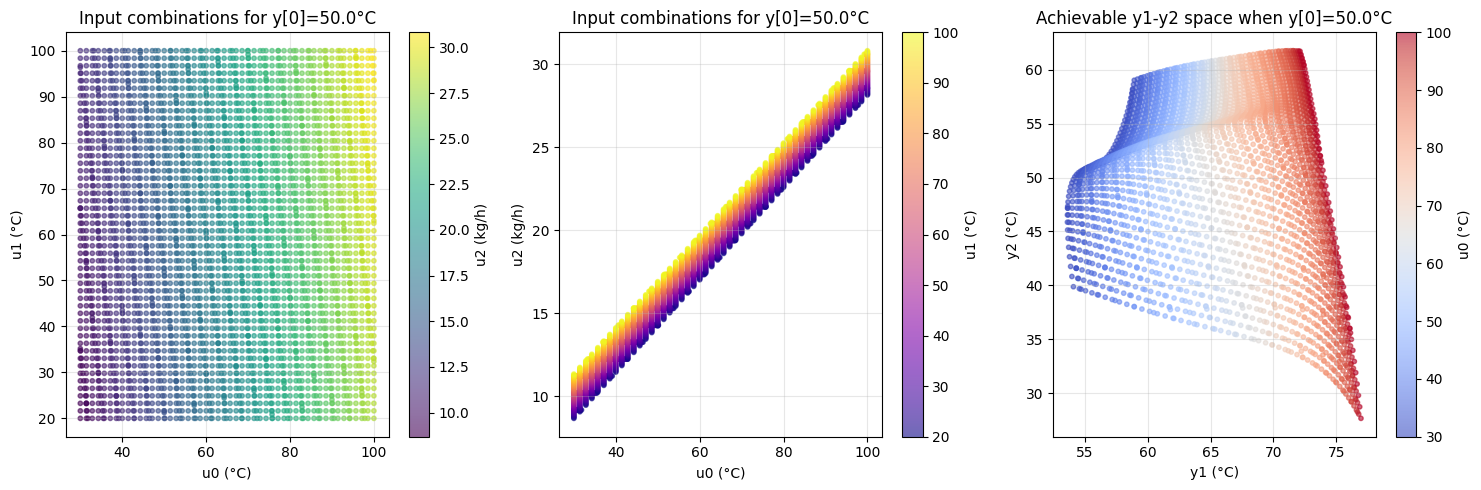

In [113]:
# Visualize the solution space
fig = plt.figure(figsize=(15, 5))

# Plot 1: u0 vs u1, colored by u2
ax1 = fig.add_subplot(131)
scatter1 = ax1.scatter(valid_u[:, 0], valid_u[:, 1], c=valid_u[:, 2], 
                       cmap='viridis', alpha=0.6, s=10)
ax1.set_xlabel('u0 (°C)')
ax1.set_ylabel('u1 (°C)')
ax1.set_title(f'Input combinations for y[0]={target_y0}°C')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='u2 (kg/h)')

# Plot 2: u0 vs u2, colored by u1
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(valid_u[:, 0], valid_u[:, 2], c=valid_u[:, 1], 
                       cmap='plasma', alpha=0.6, s=10)
ax2.set_xlabel('u0 (°C)')
ax2.set_ylabel('u2 (kg/h)')
ax2.set_title(f'Input combinations for y[0]={target_y0}°C')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='u1 (°C)')

# Plot 3: Output space (y1 vs y2), colored by which input is dominant
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(valid_y[:, 1], valid_y[:, 2], c=valid_u[:, 0], 
                       cmap='coolwarm', alpha=0.6, s=10)
ax3.set_xlabel('y1 (°C)')
ax3.set_ylabel('y2 (°C)')
ax3.set_title(f'Achievable y1-y2 space when y[0]={target_y0}°C')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='u0 (°C)')

plt.tight_layout()
plt.show()

### Problem 2: Find all input combinations for given output 1 and 2 references

With 2 constraints (y[1] = target1, y[2] = target2) and 3 inputs, we have 1 degree of freedom.
We'll parameterize the solution by sweeping one input and solving for the other two.

**Note:** The linearized G matrix provides fast approximate solutions. For exact results, use `verify=True`.

In [114]:
def find_inputs_for_two_outputs(output_indices, target_values_ns, u_min_ns, u_max_ns,
                                scaler, scalerU, G, num_samples=200, verify=True):
    """
    Find all input combinations that achieve targets for two outputs.
    Uses linearized steady-state model (G matrix) for initial search.
    
    Parameters:
    - output_indices: tuple of two output indices to control, e.g., (1, 2)
    - target_values_ns: tuple of target values in non-scaled units
    - u_min_ns, u_max_ns: input bounds in non-scaled units
    - scaler, scalerU: scalers for outputs and inputs
    - G: steady-state gain matrix (3x3) - linearization around u=0
    - num_samples: number of points to sample for the free input
    - verify: if True, compute actual steady-state outputs (slower but accurate)
    
    Returns:
    - valid_inputs_ns: array of valid input combinations (N x 3)
    - resulting_outputs_ns: corresponding outputs (N x 3)
    """
    
    idx1, idx2 = output_indices
    target1_ns, target2_ns = target_values_ns
    
    # Scale the targets using the scaler's mean and scale for each output
    target1 = (target1_ns - scaler.mean_[idx1]) / scaler.scale_[idx1]
    target2 = (target2_ns - scaler.mean_[idx2]) / scaler.scale_[idx2]
    
    # We use linearization: y ≈ G @ u (valid near u=0)
    # Two equations: y[idx1] = G[idx1, :] @ u = target1
    #                y[idx2] = G[idx2, :] @ u = target2
    
    u_min_scaled = scalerU.transform(u_min_ns.reshape(1, -1))[0]
    u_max_scaled = scalerU.transform(u_max_ns.reshape(1, -1))[0]
    
    valid_inputs = []
    valid_outputs = []
    
    # For each possible free parameter
    for free_idx in range(3):
        # Indices we'll solve for
        solve_indices = [i for i in range(3) if i != free_idx]
        
        # Extract the 2x2 submatrix for the two outputs and two inputs we're solving for
        G_sub = G[np.ix_([idx1, idx2], solve_indices)]
        
        # Check if this submatrix is invertible
        if np.abs(np.linalg.det(G_sub)) < 1e-10:
            continue
        
        # Invert the submatrix
        G_sub_inv = np.linalg.inv(G_sub)
        
        # Sample the free input
        u_free_samples = np.linspace(u_min_scaled[free_idx], 
                                     u_max_scaled[free_idx], num_samples)
        
        for u_free in u_free_samples:
            # Solve for the other two inputs using linearization
            g_free_col = G[np.ix_([idx1, idx2], [free_idx])].flatten()
            targets = np.array([target1, target2])
            rhs = targets - g_free_col * u_free
            
            u_solved = G_sub_inv @ rhs
            
            # Check if solved inputs are within bounds
            if (u_min_scaled[solve_indices[0]] <= u_solved[0] <= u_max_scaled[solve_indices[0]] and
                u_min_scaled[solve_indices[1]] <= u_solved[1] <= u_max_scaled[solve_indices[1]]):
                
                # Construct full input vector
                u_scaled = np.zeros(3)
                u_scaled[free_idx] = u_free
                u_scaled[solve_indices[0]] = u_solved[0]
                u_scaled[solve_indices[1]] = u_solved[1]
                
                # Compute resulting outputs
                if verify:
                    # Use actual nonlinear model
                    y_scaled = compute_steady_state_output(u_scaled)
                else:
                    # Use linearization
                    y_scaled = G @ u_scaled
                
                valid_inputs.append(u_scaled)
                valid_outputs.append(y_scaled)
    
    if len(valid_inputs) == 0:
        print(f"No valid input combinations found for y[{idx1}]={target1_ns}, y[{idx2}]={target2_ns}")
        return np.array([]), np.array([])
    
    valid_inputs = np.array(valid_inputs)
    valid_outputs = np.array(valid_outputs)
    
    # Convert back to non-scaled
    valid_inputs_ns = scalerU.inverse_transform(valid_inputs)
    valid_outputs_ns = scaler.inverse_transform(valid_outputs)
    
    return valid_inputs_ns, valid_outputs_ns

In [124]:
# Example: Find all input combinations that achieve y[1] = 72.0 and y[2] = 63.0
target_y1 = 50.0
target_y2 = 60.0

print(f"Finding all input combinations for y[1] = {target_y1}°C and y[2] = {target_y2}°C")
print("Note: Using linearized model. Set verify=True for exact nonlinear results (slower).")
print("=" * 80)

# Use same input bounds as above
u_min_ns = np.array([[30.0, 20.0, 0.0]])   # [°C, °C, kg/h]
u_max_ns = np.array([[100.0, 100.0, 50.0]]) # [°C, °C, kg/h]

valid_u2, valid_y2 = find_inputs_for_two_outputs(
    output_indices=(0, 1),
    target_values_ns=(target_y1, target_y2),
    u_min_ns=u_min_ns,
    u_max_ns=u_max_ns,
    scaler=scaler,
    scalerU=scalerU,
    G=G,
    num_samples=200,
    verify=True  # Set to True for exact results using nonlinear decoder
)

print(f"\nFound {len(valid_u2)} valid input combinations")

if len(valid_u2) > 0:
    # Show first 10 and last 10 to see the range
    print(f"\nFirst 10 combinations:")
    print("  u0 (°C)  |  u1 (°C)  |  u2 (kg/h) || y0 (°C) | y1 (°C) | y2 (°C)")
    print("-" * 80)
    for i in range(min(10, len(valid_u2))):
        print(f"{valid_u2[i, 0]:8.2f} | {valid_u2[i, 1]:8.2f} | {valid_u2[i, 2]:10.2f} || "
              f"{valid_y2[i, 0]:7.2f} | {valid_y2[i, 1]:7.2f} | {valid_y2[i, 2]:7.2f}")
    
    if len(valid_u2) > 10:
        print(f"\nLast 10 combinations:")
        print("  u0 (°C)  |  u1 (°C)  |  u2 (kg/h) || y0 (°C) | y1 (°C) | y2 (°C)")
        print("-" * 80)
        for i in range(max(0, len(valid_u2)-10), len(valid_u2)):
            print(f"{valid_u2[i, 0]:8.2f} | {valid_u2[i, 1]:8.2f} | {valid_u2[i, 2]:10.2f} || "
                  f"{valid_y2[i, 0]:7.2f} | {valid_y2[i, 1]:7.2f} | {valid_y2[i, 2]:7.2f}")
    
    # Summary statistics
    print(f"\n\nInput ranges for y[1] = {target_y1}, y[2] = {target_y2}:")
    print(f"  u0: [{valid_u2[:, 0].min():.2f}, {valid_u2[:, 0].max():.2f}] °C")
    print(f"  u1: [{valid_u2[:, 1].min():.2f}, {valid_u2[:, 1].max():.2f}] °C")
    print(f"  u2: [{valid_u2[:, 2].min():.2f}, {valid_u2[:, 2].max():.2f}] kg/h")
    print(f"\nResulting output ranges:")
    print(f"  y0: [{valid_y2[:, 0].min():.2f}, {valid_y2[:, 0].max():.2f}] °C")
    print(f"  y1: [{valid_y2[:, 1].min():.2f}, {valid_y2[:, 1].max():.2f}] °C (target: {target_y1:.2f})")
    print(f"  y2: [{valid_y2[:, 2].min():.2f}, {valid_y2[:, 2].max():.2f}] °C (target: {target_y2:.2f})")
    print(f"Number of valid solutions: {len(valid_u2)}")

Finding all input combinations for y[1] = 50.0°C and y[2] = 60.0°C
Note: Using linearized model. Set verify=True for exact nonlinear results (slower).

Found 226 valid input combinations

First 10 combinations:
  u0 (°C)  |  u1 (°C)  |  u2 (kg/h) || y0 (°C) | y1 (°C) | y2 (°C)
--------------------------------------------------------------------------------
   46.53 |    26.64 |      13.50 ||   42.25 |   59.45 |   41.63
   46.88 |    33.52 |      13.83 ||   45.89 |   58.78 |   45.63
   47.24 |    40.40 |      14.15 ||   48.94 |   58.46 |   49.09
   47.59 |    47.28 |      14.48 ||   50.99 |   58.49 |   51.58
   47.94 |    54.16 |      14.81 ||   51.64 |   58.96 |   52.82
   48.29 |    61.04 |      15.14 ||   51.25 |   59.67 |   53.09
   48.64 |    67.93 |      15.46 ||   50.97 |   60.49 |   53.35
   48.99 |    74.81 |      15.79 ||   51.89 |   61.27 |   54.41
   49.35 |    81.69 |      16.12 ||   53.56 |   61.83 |   55.87
   49.70 |    88.57 |      16.45 ||   55.52 |   62.24 |   57.50



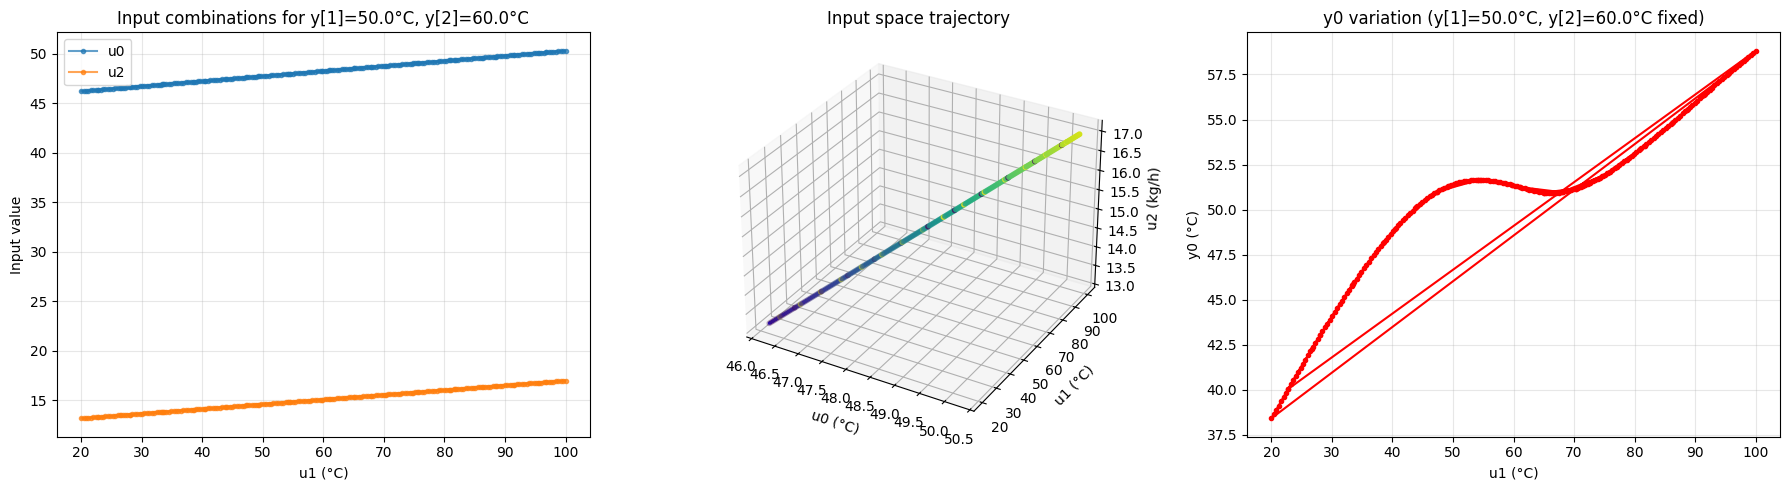

In [125]:
# Visualize the solution space for two-output constraint
if len(valid_u2) > 0:
    fig = plt.figure(figsize=(18, 5))
    
    # Plot 1: All three inputs along the solution curve
    ax1 = fig.add_subplot(131)
    # Find which input varies most to use as x-axis
    input_ranges = [valid_u2[:, i].max() - valid_u2[:, i].min() for i in range(3)]
    varying_idx = np.argmax(input_ranges)
    
    for i in range(3):
        if i != varying_idx:
            ax1.plot(valid_u2[:, varying_idx], valid_u2[:, i], 'o-', 
                    label=f'u{i}', alpha=0.7, markersize=3)
    ax1.set_xlabel(f'u{varying_idx} ({"°C" if varying_idx < 2 else "kg/h"})')
    ax1.set_ylabel('Input value')
    ax1.set_title(f'Input combinations for y[1]={target_y1}°C, y[2]={target_y2}°C')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: 3D plot of input space
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(valid_u2[:, 0], valid_u2[:, 1], valid_u2[:, 2], 'b-', linewidth=2)
    ax2.scatter(valid_u2[:, 0], valid_u2[:, 1], valid_u2[:, 2], 
               c=np.arange(len(valid_u2)), cmap='viridis', s=10)
    ax2.set_xlabel('u0 (°C)')
    ax2.set_ylabel('u1 (°C)')
    ax2.set_zlabel('u2 (kg/h)')
    ax2.set_title('Input space trajectory')
    
    # Plot 3: y0 variation along the solution
    ax3 = fig.add_subplot(133)
    ax3.plot(valid_u2[:, varying_idx], valid_y2[:, 0], 'ro-', markersize=3)
    ax3.set_xlabel(f'u{varying_idx} ({"°C" if varying_idx < 2 else "kg/h"})')
    ax3.set_ylabel('y0 (°C)')
    ax3.set_title(f'y0 variation (y[1]={target_y1}°C, y[2]={target_y2}°C fixed)')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid solutions to visualize")

### Additional Analysis: Verify solutions with simulation

In [117]:
# Verify a few solutions by simulating them to steady state
def verify_steady_state(u_ns, scalerU, scaler, num_steps=1000):
    """Simulate a constant input to steady state and return the output."""
    u_scaled = scalerU.transform(u_ns.reshape(1, -1)).reshape(-1, 1)
    baseline_inference.get_x(np.zeros((3, 1)))
    
    for _ in range(num_steps):
        y = baseline_inference.y_plus(u_scaled)
    
    y_ns = scaler.inverse_transform(y.reshape(1, -1))[0]
    return y_ns

# Test a few solutions for Problem 2
if len(valid_u2) > 0:
    print("Verification: Simulating selected input combinations to steady state")
    print("=" * 80)
    print("Expected: y[1] ≈ {:.2f}°C, y[2] ≈ {:.2f}°C\n".format(target_y1, target_y2))
    
    # Test first, middle, and last solutions
    test_indices = [0, len(valid_u2)//2, len(valid_u2)-1]
    
    print("  u0 (°C)  |  u1 (°C)  |  u2 (kg/h) || Simulated y0 | y1 | y2")
    print("-" * 80)
    
    for idx in test_indices:
        u_test = valid_u2[idx]
        y_simulated = verify_steady_state(u_test, scalerU, scaler)
        
        print(f"{u_test[0]:8.2f} | {u_test[1]:8.2f} | {u_test[2]:10.2f} || "
              f"{y_simulated[0]:7.2f} | {y_simulated[1]:7.2f} | {y_simulated[2]:7.2f}")
    
    print("\nNote: Small differences may occur due to numerical precision")

In [118]:
u = u = np.array([[-.5], [1.5], [1.0]])
baseline_inference.get_x(np.zeros((3, 1)))
for i in range(1000):
    y = baseline_inference.y_plus(u)
print(scaler.inverse_transform(y.reshape(1, -1))[0])

[74.00717 79.91173 75.46197]
